In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import json
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm import tqdm

from lifelines.plotting import plot_lifetimes
from numpy.random import uniform, exponential

from sksurv.nonparametric import kaplan_meier_estimator
from lifelines import KaplanMeierFitter
from lifelines import WeibullFitter
from lifelines import CoxPHFitter

from sksurv.preprocessing import OneHotEncoder

from sklearn.preprocessing import LabelEncoder

from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis

import seaborn as sns

# import altair as alt

# pd.set_option('mode.chained_assignment', None)

In [2]:

# Use to restrict x-axis when displaying time-related data
DATE_RANGE = (pd.to_datetime('2016-09'), pd.to_datetime('2019-06-01'))

FIG_SIZE = (10, 6)
PALETTE = sns.color_palette()
plt.rcParams['figure.figsize'] = FIG_SIZE

def savefig(fig, name):
    fig.savefig(
        os.path.join('..', 'figures', '{}.pdf'.format(name)),
        bbox_inches='tight'
    )

### Load Dataset

In [10]:
df_v6 = pd.read_csv("../data/repoissuedata_v6.csv.gz", compression='gzip')
df_v6

,message,line,column,kind,snippet,end_column,file_hash,repository,commit_hash,author_name,...,git_change_type,uid,next_commit_hash,status,error_count,time_lapse,date,time,next_date,Rule
0,"undefined variable ""go"". available variables a...",15,30,expression,working-directory: ${{ go.module-path }}...,43,e4d71b496daf910760a618e45146cb4f69a8894ae1212b...,filhodanuvem/gitql,cc252e32322cbf19984cc0881d5c3961a8be6b65,Claudson Oliveira,...,R,filhodanuvem---gitql/.github/workflows/ci.yml/...,d936e682f76c93079bdcdc369309e8f60db1645f,closed,1.0,0 days 00:00:00,2019-08-08,23:40:21,2019-08-08,Bugs - Blocker
1,"undefined variable ""go"". available variables a...",19,30,expression,working-directory: ${{ go.module-path }}...,43,e4d71b496daf910760a618e45146cb4f69a8894ae1212b...,filhodanuvem/gitql,cc252e32322cbf19984cc0881d5c3961a8be6b65,Claudson Oliveira,...,R,filhodanuvem---gitql/.github/workflows/ci.yml/...,d936e682f76c93079bdcdc369309e8f60db1645f,closed,0.0,0 days 00:00:00,2019-08-08,23:40:21,2019-10-28,Bugs - Blocker
2,"undefined variable ""go"". available variables a...",19,30,expression,working-directory: ${{ go.module-path }}...,43,e4d71b496daf910760a618e45146cb4f69a8894ae1212b...,filhodanuvem/gitql,cc252e32322cbf19984cc0881d5c3961a8be6b65,Claudson Oliveira,...,R,filhodanuvem---gitql/.github/workflows/ci.yml/...,d936e682f76c93079bdcdc369309e8f60db1645f,closed,1.0,0 days 00:00:00,2019-08-09,23:40:21,2019-10-28,Bugs - Blocker
3,"undefined variable ""go"". available variables a...",19,30,expression,working-directory: ${{ go.module-path }}...,43,e4d71b496daf910760a618e45146cb4f69a8894ae1212b...,filhodanuvem/gitql,cc252e32322cbf19984cc0881d5c3961a8be6b65,Claudson Oliveira,...,R,filhodanuvem---gitql/.github/workflows/ci.yml/...,d936e682f76c93079bdcdc369309e8f60db1645f,closed,1.0,0 days 00:00:00,2019-08-10,23:40:21,2019-10-28,Bugs - Blocker
4,"undefined variable ""go"". available variables a...",19,30,expression,working-directory: ${{ go.module-path }}...,43,e4d71b496daf910760a618e45146cb4f69a8894ae1212b...,filhodanuvem/gitql,cc252e32322cbf19984cc0881d5c3961a8be6b65,Claudson Oliveira,...,R,filhodanuvem---gitql/.github/workflows/ci.yml/...,d936e682f76c93079bdcdc369309e8f60db1645f,closed,1.0,0 days 00:00:00,2019-08-11,23:40:21,2019-10-28,Bugs - Blocker
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6850921,"property ""versioning"" is not defined in object...",13,21,expression,new-tag: v${{ steps.versioning.outputs.n...,52,37db5a30e8968384dada935e09695e7835ee88c52225b7...,rospino74/quizlet-bypass,8aa9b8a890f8300ec727f06671e3b848713e5dec,Marko,...,M,rospino74---quizlet-bypass/.github/workflows/p...,a4fcc7a18597970ea6a6501ad8084a43c65d480f,open,0.0,0 days 00:00:00,2023-10-11,18:03:08,2023-10-11,Bugs - Blocker
6850922,"property ""versioning"" is not defined in object...",30,35,expression,run: |,35,d695aba7f39862cf7573a7c007fc5a8e42230184f75601...,rospino74/quizlet-bypass,a4fcc7a18597970ea6a6501ad8084a43c65d480f,Marko,...,M,rospino74---quizlet-bypass/.github/workflows/p...,NaN,closed,1.0,0 days 00:00:01,2023-10-11,18:03:09,2023-10-11,Bugs - Blocker
6850923,"property ""versioning"" is not defined in object...",13,21,expression,new-tag: v${{ steps.versioning.outputs.n...,52,d695aba7f39862cf7573a7c007fc5a8e42230184f75601...,rospino74/quizlet-bypass,a4fcc7a18597970ea6a6501ad8084a43c65d480f,Marko,...,M,rospino74---quizlet-bypass/.github/workflows/p...,NaN,closed,0.0,0 days 00:00:01,2023-10-11,18:03:09,2023-10-12,Bugs - Blocker
6850924,"label ""domestic"" is unknown. available labels ...",9,28,runner-label,"runs-on: [self-hosted, domestic]\n ...",36,c67c0c60455262703d673a4ee96c93bc309715eb154ad9...,cloudwego/cloudwego.github.io,060e6c313139189c91d0043ab1c44df70052aa33,copy rogers,...,M,cloudwego---cloudwego.github.io/.github/workfl...,NaN,closed,1.0,0 days 00:00:00,2023-10-12,04:43:43,2023-10-12,Bugs - Blocker


In [11]:
df_v6.columns

Index(['message', 'line', 'column', 'kind', 'snippet', 'end_column',
       'file_hash', 'repository', 'commit_hash', 'author_name', 'author_email',
       'committer_name', 'committer_email', 'committed_date', 'authored_date',
       'file_path', 'previous_file_path', 'previous_file_hash',
       'git_change_type', 'uid', 'next_commit_hash', 'status', 'error_count',
       'time_lapse', 'date', 'time', 'next_date', 'Rule'],
      dtype='object')

In [12]:
df_v6 = df_v6[['message', 'line', 'column', 'kind', 'snippet', 'end_column','file_hash', 'repository', 
               'commit_hash', 'author_name', 'author_email','committer_name', 'committer_email', 
               'committed_date', 'authored_date','file_path', 'previous_file_path', 'previous_file_hash',
               'git_change_type', 'uid', 'next_commit_hash', 'status', 'error_count','time_lapse','Rule']]

###  EDA Question

Here a some ideas of preliminary analyses that you can conduct as soon 
as you have a dataset of "workflow ids". I phrased them as questions. By 
"workflows" or "workflow files", I mean "alive workflow ids":

** Dataset overview:
  - How many workflows are there over time?
  - How many repositories with workflows are there over time?

** Issue dataset overview:
  - How many workflows with at least one issue are there over time?
  - How many workflows have issues, per issue category, over time?
  - What's the proportion of workflows with at least one issue, over time?
  - What's the proportion of workflows having issues, per issue 
category, over time?
  - All the above 4 items, but this time by reporting on the "time 
elapsed since the workflow was added to the repository" instead of 
absolute dates;
  - All the above first 4 items, but this time by reporting on the "time 
elapsed since *a first* workflow was added to the repository";

** Last snapshot:
  - How many workflows have issues in the latest snapshot? How many 
repositories have workflows with issues? (absolute numbers + proportions)
  - What's the distribution of the number of issues for workflows with 
issues?
  - What's the distribution of the number of issues for repositories 
(including those that have no issue)?
  - Same than the last two items, but by category of issues?
  - What are the most frequent combinations of issues (per repository; 
per workflow id)?

** Evolution:
Since we detect issues based on "numbers" (i.e., we cannot keep track of 
each issue, we just got the number of issues of each type), we'll 
envision 2 scenarii: the "optimistic" one where a decrease in a number 
of issues mean the latest added issues were removed, and a "pessimistic" 
one where a decrease in a number of issues mean the first added issues 
were removed.
  - How long does it take for an issue (per category type) to be 
introduced in a workflow?
  - Same, but for repositories;
  - How long does it take for an issue (per category type) to be 
removed? (first only for issues that were actually removed, then a 
survival analysis so we can take into account the ones that were not yet 
removed)
  - Same, but for repositories;


#### How many workflows are there over time?

/var/folders/7d/0f182w6x04363vjqlgfndc7c0000gn/T/ipykernel_35410/294027292.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_v6['committed_date'] = pd.to_datetime(df_v6['committed_date'])


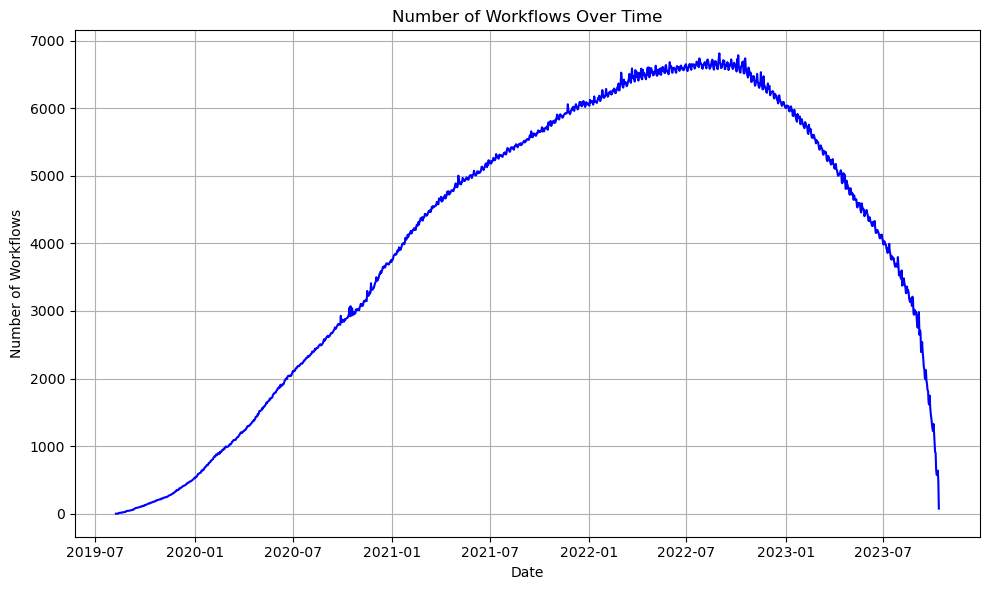

In [17]:
df_v6['committed_date'] = pd.to_datetime(df_v6['committed_date'])

# Group by commit date and count unique workflow IDs
workflow_counts = df_v6.groupby(df_v6['committed_date'].dt.date)['uid'].nunique()

# Plotting
plt.figure(figsize=(10, 6))
workflow_counts.plot(kind='line', color='blue')
plt.title('Number of Workflows Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Workflows')
plt.grid(True)
plt.tight_layout()
plt.show()